In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Build model

In [6]:
# 1. Randomly initialize parameters
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L  = len(layer_dims)

    for l in range(1, L):
        # Initializing weights and bias at layer l with normal dist.
        weights_at_l = np.random.standard_normal((layer_dims[l], layer_dims[l - 1]))
        bias_at_l = np.random.standard_normal((layer_dims[l], 1))

        # Limiting weights and bias in range [0, 0.01]
        #parameters['W' + str(l)] = np.clip(weights_at_l, 0.0, 0.01)
        #parameters['b' + str(l)] = np.clip(bias_at_l, 0.0, 0.01)
        parameters['W' + str(l)] = weights_at_l
        parameters['b' + str(l)] = bias_at_l

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

# Test
#params = initialize_parameters([1, 2, 3])
#print(params)

In [7]:
# 2. Linear combination
def linear_forward(A, W, b):
    #Z = np.dot(W, A) + b
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

# Test
A = np.random.rand(10, 100)
W = np.random.rand(200, 10)
b = np.random.rand(200, 1)
Z, cache = linear_forward(A, W, b)
print(Z.shape)

(200, 100)


In [8]:
# 3. Activation function
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(Z, 0)
    cache = Z

    return A, cache

def linear_activation_forward(A, W, b, activation):
    Z, linear_cache = linear_forward(A, W, b)
    if activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'relu':
        A, activation_cache = relu(Z)
    else:
        print('Invalid activation function')
        return
    cache = (linear_cache, activation_cache)    

    return A, cache

# Test
A, W, b = np.random.rand(10, 100), np.random.rand(200, 10), np.random.rand(200, 1)
rs, cache = linear_activation_forward(A, W, b, 'relu')
print(rs.shape)
rs, cache = linear_activation_forward(A, W, b, 'sigmoid')
print(rs.shape)

(200, 100)
(200, 100)


In [9]:
# 4. Feed forward
def model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 

    for l in range(1, L):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, 'relu')
        caches.append(cache)

    # Computing A in the last layer
    W = parameters['W' + str(l + 1)]
    b = parameters['b' + str(l + 1)]
    AL, cache = linear_activation_forward(A, W, b, 'sigmoid')
    caches.append(cache)

    return AL, caches

# Test
params = initialize_parameters([10, 3, 1])
X = np.random.rand(10, 9)
AL, caches = model_forward(X, params)
print(AL.shape)

(1, 9)


In [10]:
# 5. Cost function
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1 / m * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    #cost = -1 / m * np.sum(Y * np.log(AL) + ((1 - Y) * np.log(1 - AL)))
    cost = np.squeeze(cost)

    return cost

# Test
Y = np.array([[1, 1, 1, 0, 0, 0, 1, 1, 0]])
cost = compute_cost(AL, Y)
print(cost)

0.8915072146435766


In [11]:
# 6. Linear backward
def linear_backward(dZ, cache):
    A_pre, W, b = cache
    m = A_pre.shape[1]

    dW = 1/m * np.dot(dZ, A_pre.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_pre = np.dot(W.T, dZ)

    return dA_pre, dW, db

In [12]:
# 7. Linear-activation backward
def relu_deravative(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape) 

    return dZ

def sigmoid_deravative(dA, cache):
    Z = cache
    s, _ = sigmoid(Z)
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)

    return dZ

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == 'relu':
        dZ = relu_deravative(dA, activation_cache)
    if activation == 'sigmoid':
        dZ = sigmoid_deravative(dA, activation_cache)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [13]:
# 8. Backpropagation 
def model_backward(AL, Y, caches):
    gradients = {}
    L = len(caches)  # Num of layers
    m = AL.shape[1]

    # 1. Compute dAL
    dAL = -1/m * (Y / AL - ((1 - Y) / (1 - AL)))

    # 2. Compute dW
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    gradients["dA" + str(L - 1)] = dA_prev_temp
    gradients["dW" + str(L)] = dW_temp
    gradients["db" + str(L)] = db_temp

    # Loop from l = L - 2 to l = 0
    for l in range(L - 1)[::-1]:
        # l-th layer: (RELU -> LINEAR) gradient
        # Input: grads["dA" + str(l + 1)], current_cache
        # Output: grads["dA" + str(l)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)]
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, 'relu')
        gradients["dA" + str(l)] = dA_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp

    return gradients

In [14]:
# 9. Updating model parameters
def update_parameters(params, gradients, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2  # Num of layers

    for l in range(L):
        W_old, b_old = parameters["W" + str(l + 1)], parameters["b" + str(l + 1)]
        dW, db = gradients["dW" + str(l + 1)], gradients["db" + str(l + 1)]

        parameters["W" + str(l + 1)] = W_old - learning_rate * dW
        parameters["b" + str(l + 1)] = b_old - learning_rate * db
        #print(l + 1, b_old.shape)
        #print(l + 1, db.shape)
        #print(l + 1, parameters["b" + str(l + 1)].shape)
    
    return parameters

In [15]:
# 10. Predict func
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2  # Num of layers
    p = np.zeros((1, m))

    # Feed forward
    probas, _ = model_forward(X, parameters)
    p = probas.copy()

    # Convert probas to 0/1 predictions
    i, j = np.where(p > 0.5)
    p[i, j] = 1
    i, j = np.where(p <= 0.5)
    p[i, j] = 0

    print("Predictions: ", str(p))
    print("Ground truth label: ", str(y))
    print("Accuracy: " + str(np.sum((p == y)/m)))

    return p

# Test
params = initialize_parameters([10, 3, 1])
X = np.random.rand(10, 5)
y = [0, 0, 1, 0, 1]
p = predict(X, y, params)

Predictions:  [[0. 0. 0. 0. 0.]]
Ground truth label:  [0, 0, 1, 0, 1]
Accuracy: 0.6000000000000001


In [21]:
# 11. Build entire model
def build_model(X, Y, layers_dims, learning_rate=0.1, num_iterations=1000, verbose=False):
    np.random.seed(1)
    costs = []

    # Parameter initialization
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(num_iterations):
        # Feed forward: [LINEAR -> RELU] * (L - 1) -> LINEAR -> SIGMOID
        AL, caches = model_forward(X, parameters)

        # Compute cost
        cost = compute_cost(AL, Y)

        # Backward propagation
        grads = model_backward(AL, Y, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print cost after each 100 epochs
        if verbose and i % 1000 == 0 or i == num_iterations - 1:
            print(f"Cost after iteration {i}: {np.squeeze(cost)}")
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

# Solve XOR problem

In [22]:
# 12. Solving XOR problem
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [0]])

X = X.T
Y = Y.T

print(f"The input shape is: {X.shape}")
print(f"The output shape is: {Y.shape}")

The input shape is: (2, 4)
The output shape is: (1, 4)


In [23]:
layers_dims = [2, 5, 1]
parameters, costs = build_model(X, Y, layers_dims, num_iterations=5000, verbose=True)

Cost after iteration 0: 1.4921524709624385
Cost after iteration 1000: 0.21673718423367408
Cost after iteration 2000: 0.06639340549397692
Cost after iteration 3000: 0.031751081182718785
Cost after iteration 4000: 0.0193912864471456
Cost after iteration 4999: 0.013484100756148896


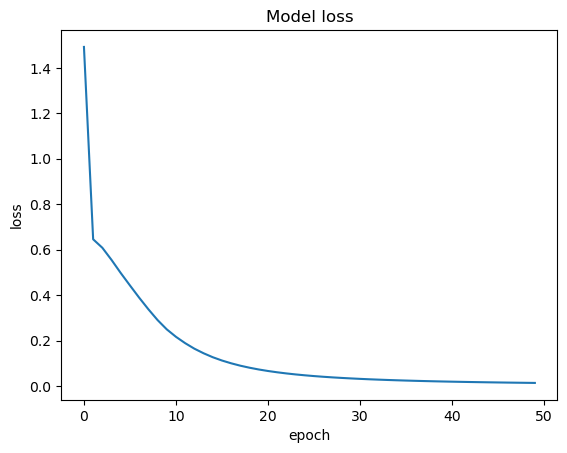

In [27]:
# Summarize history for loss
plt.plot(costs)

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

#plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
# Evaluating
x_test = np.array([0, 0])
x_test = np.expand_dims(x_test, axis=-1)
print(x_test.shape)

y_test = np.array([0])
y_test = np.expand_dims(y_test, axis=-1)
print(y_test.shape)

pred_train = predict(x_test, y_test, parameters)